<a href="https://colab.research.google.com/github/nhuang37/finegrain_expressivity_GNN/blob/main/distance_preservation/Finegrain_MPNN_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/JHU/Untrain_GNN/

/content/drive/MyDrive/JHU/Untrain_GNN


In [3]:
!pip install scipy==1.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import numpy as np
import networkx as nx
import copy
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from collections import Counter
from networkx.generators.nonisomorphic_trees import nonisomorphic_trees
import os
from sympy.utilities.iterables import multiset_permutations
import itertools
from itertools import permutations
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
np.set_printoptions(precision=4, suppress=True)

import distance #credit to Jan
#from gnn_architectures import GIN, GINE, GC


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN

from torch_geometric.utils.convert import from_networkx, from_scipy_sparse_matrix
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

from torch_geometric.nn import GINConv, GraphConv, GCNConv, global_add_pool, global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.inits import reset


In [ ]:
seed = 406
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### MPNN Models: all models default use **mean** aggregation. 
- Particularly important for the case of real-world graphs like MUTAG, where the graphs have varying sizes (otherwise the MPNN output is predominantly driven on the size of the graphs instead of their topological differences

In [44]:
# Taken from https://github.com/rusty1s/pytorch_geometric/blob/master/benchmark/kernel/gin.py.
class GIN_rep(torch.nn.Module):
    def __init__(self, input_dim, num_layers, hidden, untrain, aggr="mean"):
        super(GIN_rep, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(input_dim, hidden),
            ReLU(), #note: ReLU will zero out lots of entries, so we may get trivial output when hid_dim is too small
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
            train_eps=True, aggr=aggr)

        self.untrain = untrain

        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                    train_eps=True, aggr=aggr))
        self.aggr = aggr
           
    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

        if self.untrain:
            for param in self.conv1.parameters():
                param.requires_grad = False

            for conv in self.convs:
                for param in conv.parameters():
                    param.requires_grad = False

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)
        if self.aggr == "sum":
            x = global_add_pool(x, batch)
        else:
            x = global_mean_pool(x, batch)

        return x

    def __repr__(self):
        return self.__class__.__name__


In [8]:
class GC_rep(torch.nn.Module):
    def __init__(self, input_dim, num_layers, hidden, untrain, aggr='mean'):
        super(GC_rep, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden, aggr=aggr)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GraphConv(hidden, hidden, aggr=aggr))

        self.untrain = untrain
        self.aggr = aggr

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

        if self.untrain:
            for param in self.conv1.parameters():
                param.requires_grad = False

            for conv in self.convs:
                for param in conv.parameters():
                    param.requires_grad = False

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)

        for conv in self.convs:
            x = conv(x, edge_index)
            
        if self.aggr == "sum":
            x = global_add_pool(x, batch)
        else:
            x = global_mean_pool(x, batch)

        return x

    def __repr__(self):
        return self.__class__.__name__

In [13]:
def compute_seq_distance(graph_set, metric="Wasserstein"):
  '''
  Compute the distance metric of the graph set w.r.t last element
  Return a list of distance with length = |graph_set|
  '''
  num_G = len(graph_set)
  seq_dist = np.zeros(num_G)
  for i in range(num_G-1):
    if metric == "Wasserstein":
      dist = distance.demoRun(graph_set[i], graph_set[-1],"Wasserstein distance", "flow, at most 3 iterations after refinement", 
                              distance.wassersteinMinCostFlow, convIterationBound = 3)
    elif metric == "Euclidean":
      assert type(graph_set[0]) == torch.Tensor, "must pass in graph Euclidean embedding!"
      dist = torch.linalg.vector_norm(graph_set[i] - graph_set[-1])
    else:
      NotImplementedError
    seq_dist[i] = dist

  return seq_dist

In [46]:
def get_MPNN_embed(graph_loader, input_dim, hid_dim, num_layers, aggr="sum"):
  #untrain GNN
  GIN_block = GIN_rep(input_dim, num_layers, hid_dim, untrain=True, aggr=aggr)
  GIN_block.reset_parameters() #.to(device)
  GC_block = GC_rep(input_dim, num_layers, hid_dim, untrain=True, aggr=aggr)
  GC_block.reset_parameters()
  #forward pass: obtain untrained graph embedding
  MPNN_embeds = {'GIN':[], 'GC':[]}
  for data in graph_loader:
    #data = data.to(device)
    #print(GIN_block(data))
    MPNN_embeds['GIN'].append(GIN_block(data))
    MPNN_embeds['GC'].append(GC_block(data))
  return MPNN_embeds

In [87]:
def embed_vary(graph_loader, input_dim, hid_dim, num_layers, dimensions, vary="hid_dim", aggr="mean"):
  '''
  vary hid_dim or layer
  '''
  results_all = []
  for d in dimensions:
    while True: #make sure simulating non-degerate stuff
      if vary=="hid_dim":
        MPNN_embeds = get_MPNN_embed(graph_loader, input_dim, d, num_layers, aggr=aggr)
      else:
        MPNN_embeds = get_MPNN_embed(graph_loader, input_dim, hid_dim, d, aggr=aggr)
      x = MPNN_embeds['GIN'][0] 
      if not (x[0]==x).all().item():
        break

    GIN_dist = compute_seq_distance(MPNN_embeds['GIN'][0], metric="Euclidean")
    GC_dist = compute_seq_distance(MPNN_embeds['GC'][0], metric="Euclidean")
    print(f"GIN_dist_max={GIN_dist.max()}, GC_dist_max={GC_dist.max()}")
    results_all.append((GIN_dist, GC_dist))
  return results_all

In [112]:
def plot_result_vary(graph_dist, results_all, hid_dim, num_layers, dimensions, vary="hid_dim"):
  '''
  graph_dist: a list of graph distances
  results_all: a list of (GIN_dict, GC_dist)
  dimensions: a list of hid_dim or a list of layers
  vary: flag to highlight whether it is varying hid_dim or layer
  '''
  fig, axs = plt.subplots(ncols=len(dimensions), nrows=2, sharex=True, sharey=True, figsize=(10,8), dpi=120)
  for i in range(len(results_all)):
    GIN_dist, GC_dist = results_all[i]
    if vary == "layer":
      spec = f"({dimensions[i]}-layer, {hid_dim}-d)"
    else:
      spec = f"({num_layers}-layer, {dimensions[i]}-d)"

    axs[0, i].scatter(graph_dist/graph_dist.max(), GIN_dist/GIN_dist.max(), s=5)
    axs[0, i].set_title(f"GIN {spec}")

    axs[1, i].scatter(graph_dist/graph_dist.max(), GC_dist/GC_dist.max(), s=5)
    axs[1, i].set_title(f"GraphConv {spec}")

  lims = [0, 1.1]

  for ax in axs.flat:
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlabel(r"Graph distance $\frac{\delta_W(G_i, G)}{\max_{i} \, \delta_W(G_i, G)}$", ha='center')
    ax.set_ylabel(r"MPNN distance $\frac{\| \varphi(G_i) - \varphi(G) \|}{\max_{i} \, \| \varphi(G_i) - \varphi(G) \|}$", va='center', rotation='vertical', labelpad=10)

  fig.tight_layout()
  plt.xlim(lims[0],lims[1])
  plt.ylim(lims[0],lims[1])
  plt.show()

### Simulated graphs: SBM

In [9]:
#config
#Run only once
def generate_graphs(num_G = 10, n = 30, p = 0.5, q = 0.1, seed=0):
  '''
  Simulate graphs: 
  '''
  graph_set = []
  qs = np.linspace(q, p, num_G) #generate a sequence of SBM graphs tending to ER graph
  for i in range(num_G):
    graph_set.append(
          nx.stochastic_block_model([n//2, n//2], [[p,q],[q,p]], seed=i)
      )
  return graph_set
  
num_G = 50
n = 30
p = 0.5
q = 0.1
graphs = generate_graphs(num_G, n, p, q)
graph_dist = compute_seq_distance(graphs)
#save
pickle.dump((graphs, graph_dist), open("graph_seq_dist_SBM.pkl", "wb"))

In [101]:
#load generated graphs
num_G = 50
graphs, graph_dist = pickle.load(open("graph_seq_dist_SBM.pkl", "rb"))
##for MPNN embeddings
n = 30
#constant node features
x = torch.ones((n, 1), dtype=torch.float)
#data loader
graphs_pyg = []
for G in graphs:
  A = nx.to_scipy_sparse_array(G)
  graphs_pyg.append(Data(x=x, edge_index=from_scipy_sparse_matrix(A)[0]))

graph_loader = DataLoader(graphs_pyg, batch_size=num_G)


In [15]:
torch.manual_seed(0)

# Set device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#untrain GNN
input_dim = 1 
hid_dim = 64
num_layers = 3
MPNN_embeds = get_MPNN_embed(graph_loader, input_dim, hid_dim, num_layers, aggr="sum")

In [16]:
GIN_dist = compute_seq_distance(MPNN_embeds['GIN'][0], metric="Euclidean")
GC_dist = compute_seq_distance(MPNN_embeds['GC'][0], metric="Euclidean")

In [17]:
def plot_result(graph_dist, GIN_dist, GC_dist, size=5, spec="(1-layer,128-d)"):
  fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,4), dpi=150)
  axs[0].scatter(graph_dist/graph_dist.max(), GIN_dist/GIN_dist.max(), s=size)
  axs[0].set_title(f"GIN {spec}")

  axs[1].scatter(graph_dist/graph_dist.max(), GC_dist/GC_dist.max(), s=size)
  axs[1].set_title(f"GraphConv {spec}")

  lims = [0, 1.1]

  for ax in axs:
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlabel(r"Graph distance $\frac{\delta_W(G_i, G)}{\max_{i} \, \delta_W(G_i, G)}$", ha='center')
    ax.set_ylabel(r"MPNN embedding distance $\frac{\| \varphi(G_i) - \varphi(G) \|}{\max_{i} \, \| \varphi(G_i) - \varphi(G) \|}$", va='center', rotation='vertical', labelpad=10)

  plt.xlim(lims[0],lims[1])
  plt.ylim(lims[0],lims[1])

  #plt.xlabel()
  #plt.ylabel()
  #fig.tight_layout()
  plt.show()
  #len(pair_dist[upper_mask])

GIN_dist_max=5.497131496667862e-07, GC_dist_max=1.9082797564351495e-07
GIN_dist_max=6.478888394667592e-07, GC_dist_max=3.370101069322118e-07
GIN_dist_max=6.928576112841256e-07, GC_dist_max=1.3029566616751254e-06


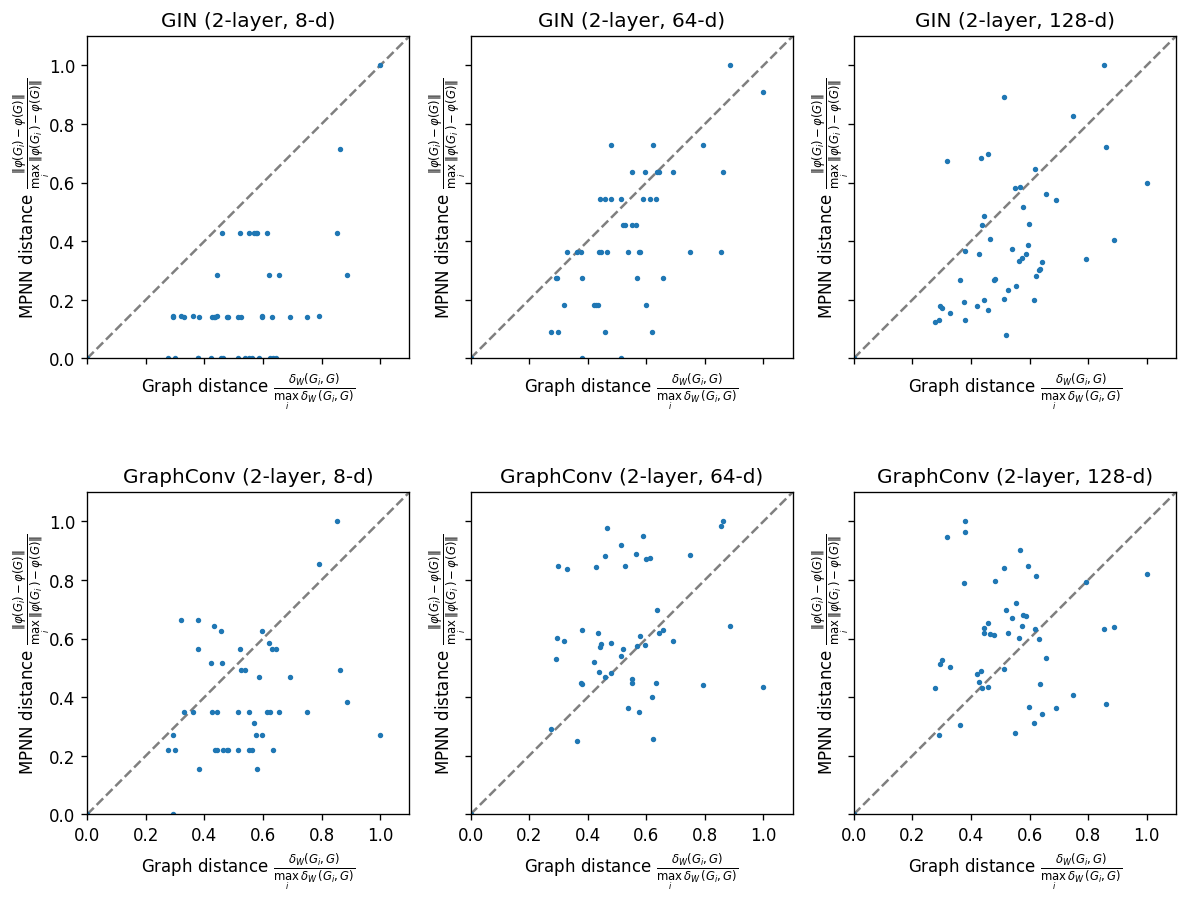

In [105]:
#untrain GNN
input_dim = 1 
hid_dim = None
num_layers = 2 #remember 1 iteration is simply the degree!
dimensions = [8,64,128]# [8,16,64]

results_hid = embed_vary(graph_loader, input_dim, hid_dim, num_layers, dimensions, vary="hid_dim", aggr="mean")
plot_result_vary(graph_dist, results_hid, hid_dim, num_layers, dimensions, vary="hid_dim")

### Real-world graphs: MUTAG

In [113]:
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.utils import to_networkx
import networkx as nx

data = "MUTAG"
path = osp.join('./datasets', data)
dataset = TUDataset(path, name=data) #.shuffle()

#### Peek at some selected graphs from MUTAG (molecules)

In [ ]:
G = to_networkx(dataset[0], to_undirected=True)
H = to_networkx(dataset[1], to_undirected=True)

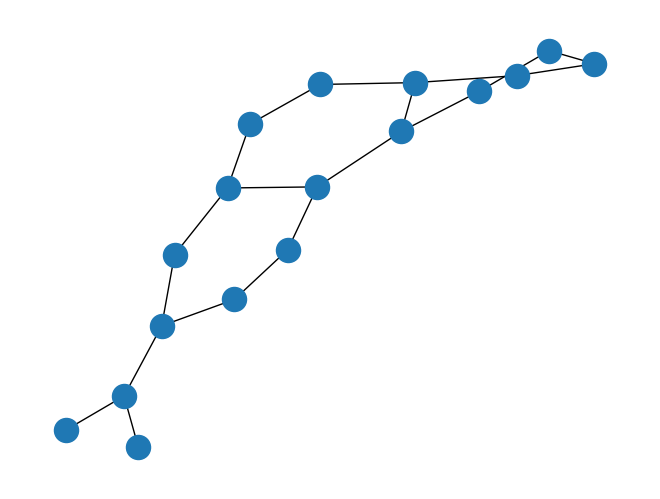

In [ ]:
nx.draw(G)

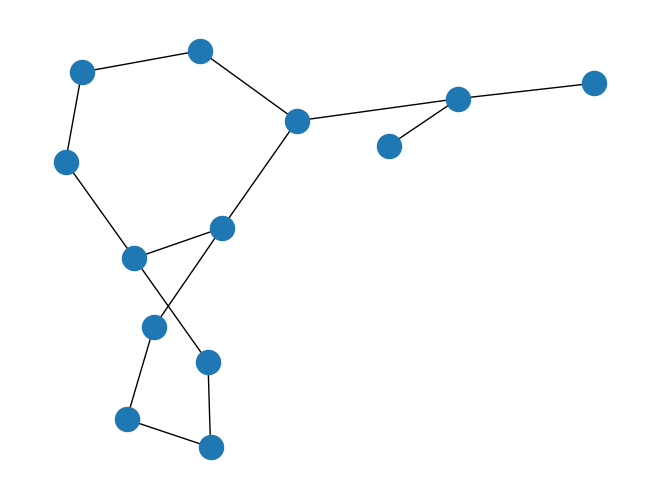

In [ ]:
nx.draw(H)

#### Compute distances

In [ ]:
#get a random subset of MUTAG graphs
graphs = [to_networkx(dataset[i], to_undirected=True) for i in range(len(dataset))]
graph_dist = compute_seq_distance(graphs)
pickle.dump((graphs, graph_dist), open("graph_seq_dist_MUTAG.pkl", "wb"))

GIN_dist_max=1.1929021104251092e-09, GC_dist_max=1.066760830781277e-07
GIN_dist_max=1.5930868846325552e-09, GC_dist_max=3.570064563973574e-07
GIN_dist_max=7.278751379402593e-09, GC_dist_max=1.7757564592102426e-06


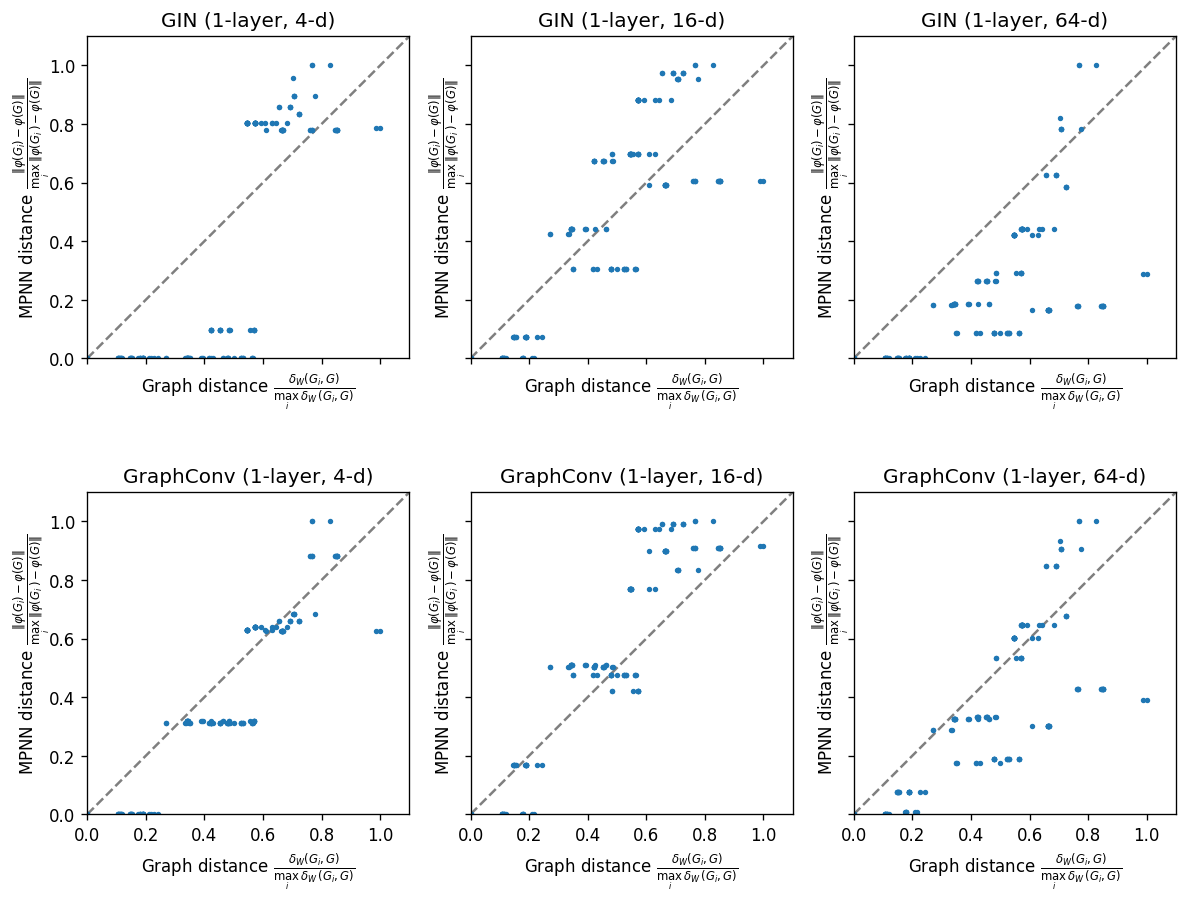

In [116]:
#MPNN embedding
##BUG: sometimes due to bad initialization, hid_dim=1, layer=1 gives trivial result => just re-run the cell
num_G = len(dataset)
graphs, graph_dist = pickle.load(open("graph_seq_dist_MUTAG.pkl", "rb"))
dataset.transform = T.Constant(value=1, cat=False)
graph_loader = DataLoader(dataset, batch_size=num_G, shuffle=False)

#untrain GNN
input_dim = 1 
hid_dim = None
num_layers = 1
dimensions = [4,16,64]

results_hid = embed_vary(graph_loader, input_dim, hid_dim, num_layers, dimensions, vary="hid_dim", aggr="mean")
plot_result_vary(graph_dist, results_hid, hid_dim, num_layers, dimensions, vary="hid_dim")

GIN_dist_max=2.799419362986555e-09, GC_dist_max=2.384185791015625e-07
GIN_dist_max=2.919681385549211e-09, GC_dist_max=3.591767097077536e-07
GIN_dist_max=3.4924596548080444e-10, GC_dist_max=6.006850128414953e-08


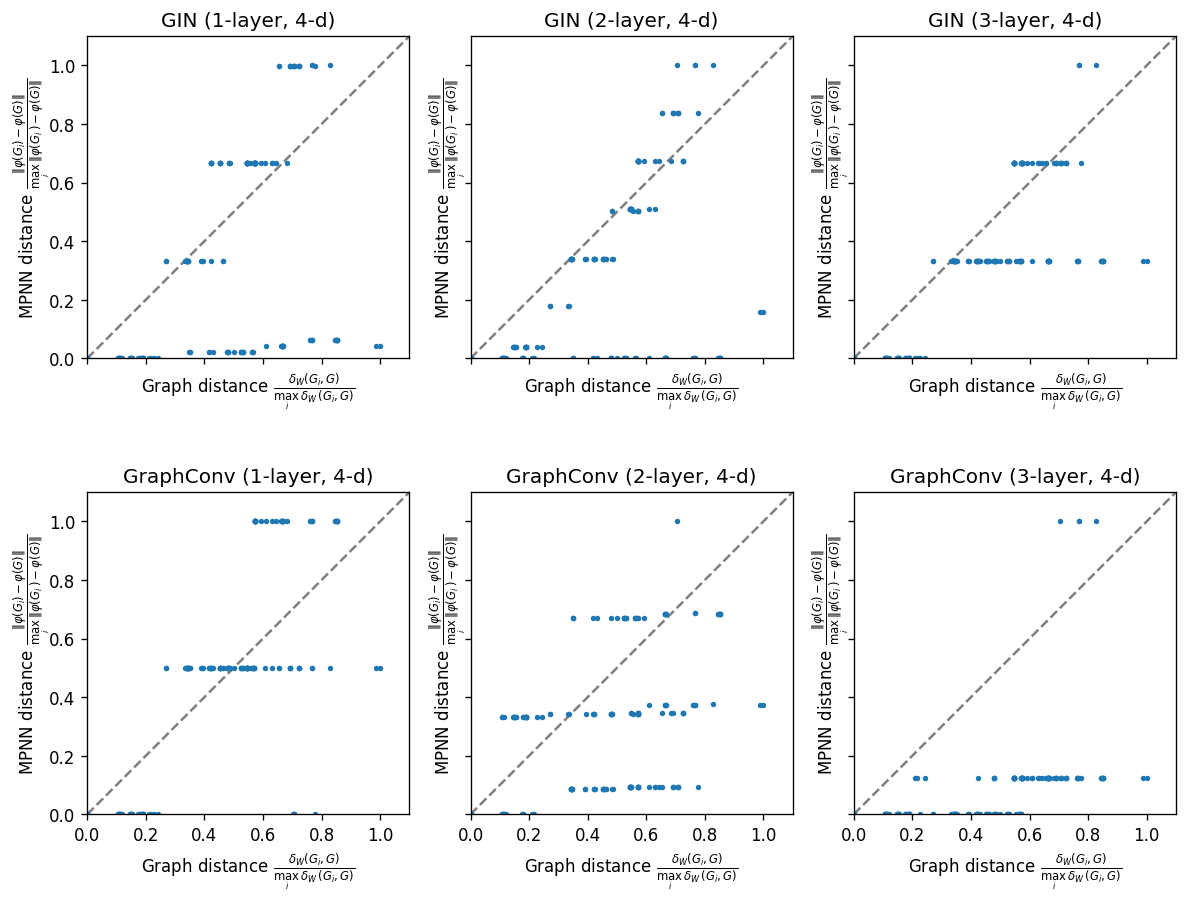

In [118]:
#untrain GNN
input_dim = 1 
hid_dim = 4 #None
num_layers = None
dimensions = [1,2,3]

results_l = embed_vary(graph_loader, input_dim, hid_dim, num_layers, dimensions, vary="layer",  aggr="mean")
plot_result_vary(graph_dist, results_l, hid_dim, num_layers, dimensions, vary="layer")